# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *
from src.helper_pipeline import *

# Configuration

In [103]:
# CONGRATULATIONS, ready to go 🚀

# DATA PREPARATION
TITLE_WORDS_MIN = 4             # the minimum number of words in the title
TITLE_WORDS_MAX = 15            # the maximum number of words in the title
TEXT_COL = 'Title_Translated'   # the text column to be used for training
TARGET_COL = 'Product Name'     # the target column to be used for training
FILER_COL = 'Length'            # the filter column to be used for training
MAX_FEATURES = 20000            # the maximum number of features for vectorizer
PRODUCT_SIZE_MAX_TRAIN = 6000   # the maximum number of samples for each product in training set to balance the data
PRODUCT_SIZE_MAX_TEST = None    # the maximum number of samples for each product in test set to balance the data
TOP_N_PRODUCTS = 25             # the top n products to be used for training, the rest will be lumped into 'Others'
PRODUCT_OTHERS = f'Other Products (not in Top {TOP_N_PRODUCTS})' # the name of the 'Others' product
# TRAINING
CLASS_WEIGHT_POWER = 0.5          # the power of the class weight. 0.5 means square root, 1 means linear, 2 means square
CLASS_WEIGHT_FACTOR = -1         # the times of the largest class as the weight of the minor classes. set to 1 to disable class weight. set to -1 no cap

# CONGRATULATIONS, ready to go 🚀

# Load Data

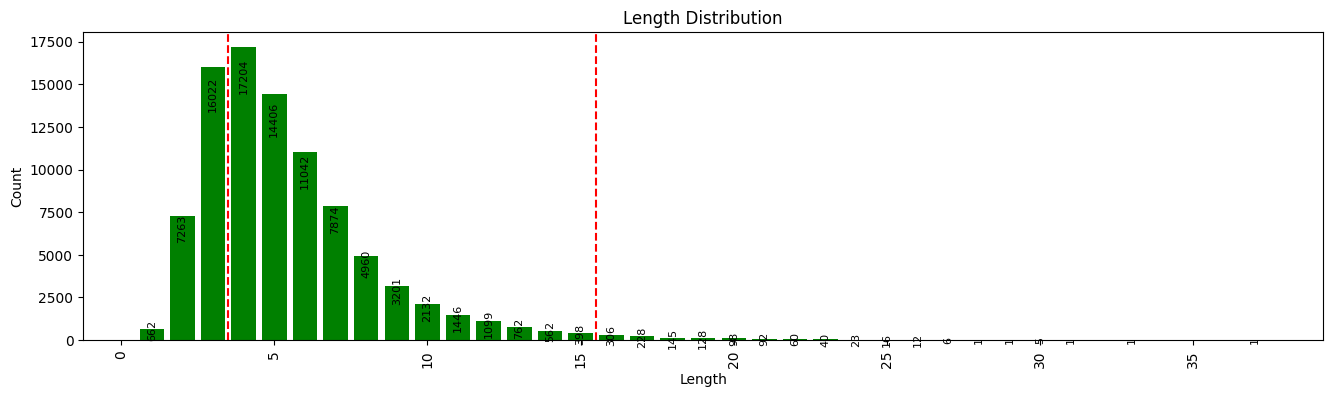

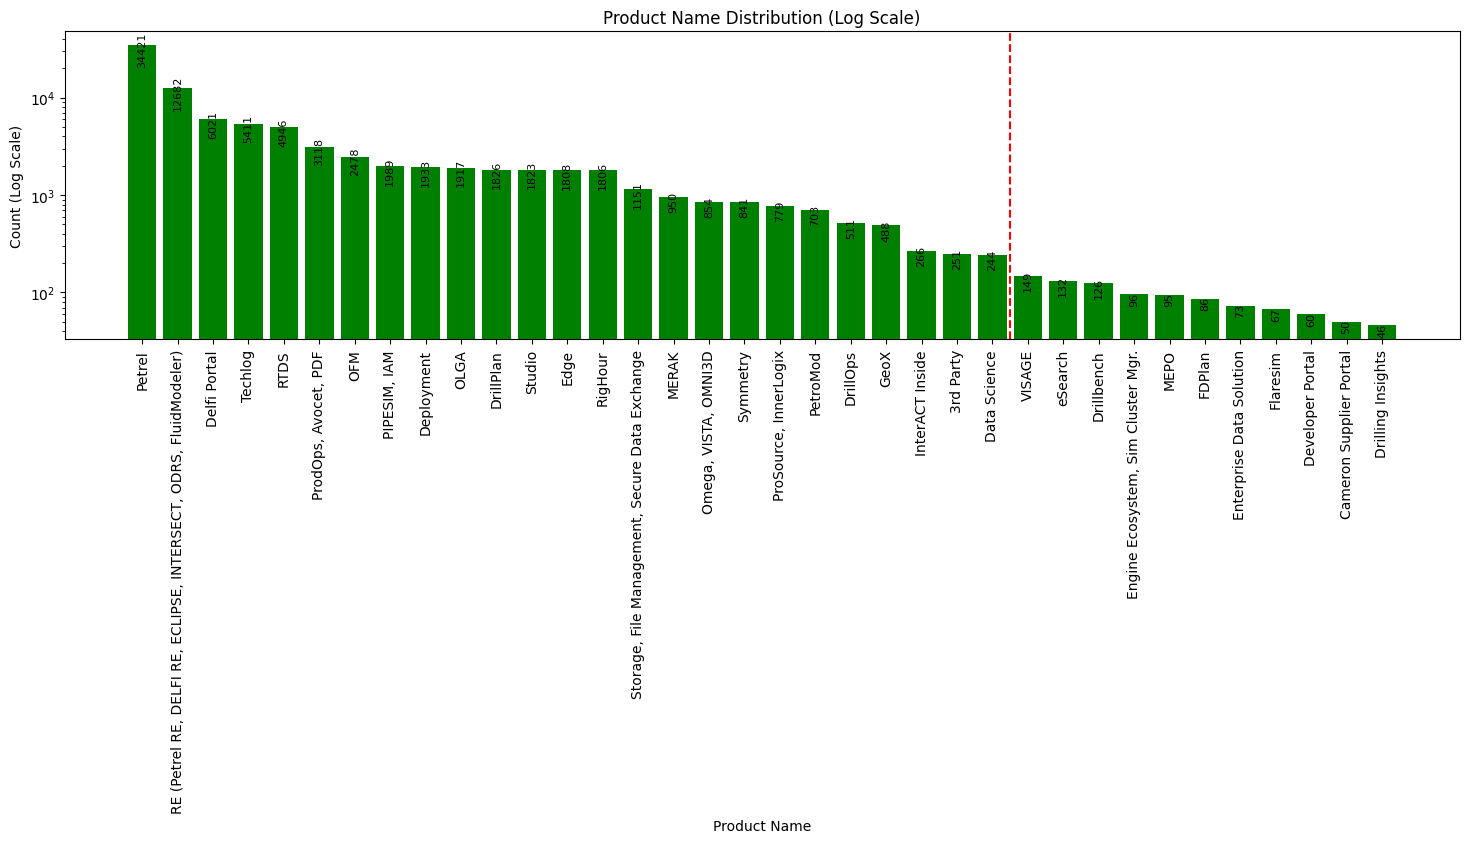

In [93]:
if 'df_train' not in locals():
    excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
    df_train = pd.read_excel(excel_file_train)
    excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
    df_test = pd.read_excel(excel_file_test)

hist_by_labels(df_train, 'Length', log=False, left=TITLE_WORDS_MIN-.5, right=TITLE_WORDS_MAX+.5)
hist_by_labels(df_train, 'Product Name', log=True, right=TOP_N_PRODUCTS-.5)

# Get the Product Name list of Top N products
def get_top_n_products(df, target_col, n):
    df_target = df[target_col].value_counts().to_frame().reset_index()
    df_target.columns = [target_col, 'count']
    df_target = df_target.sort_values(by='count', ascending=False)
    df_target = df_target.head(n)
    return df_target[target_col].tolist()

top_n_products = get_top_n_products(df_train, TARGET_COL, TOP_N_PRODUCTS)

# Train/Test Datasets

Pipeline Construction

In [99]:
# # create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
pipeline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(filter_name=FILER_COL, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL, product_name=PRODUCT_OTHERS)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

pipeline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(filter_name=FILER_COL, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL, product_name=PRODUCT_OTHERS)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

display(pipeline_data_prep_train)
display(pipeline_data_prep_test)

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(filter_name='Length', max_words=15,
                                   min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(product_name='Other Products (not in '
                                                    'Top 25)',
                                       target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Av...
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper',
                 SampleCapper(max_samples=6000, target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(filter_name='Length', max_words=15,
                                   min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(product_name='Other Products (not in '
                                                    'Top 25)',
                                       target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Av...
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper', SampleCapper(target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Data Processing

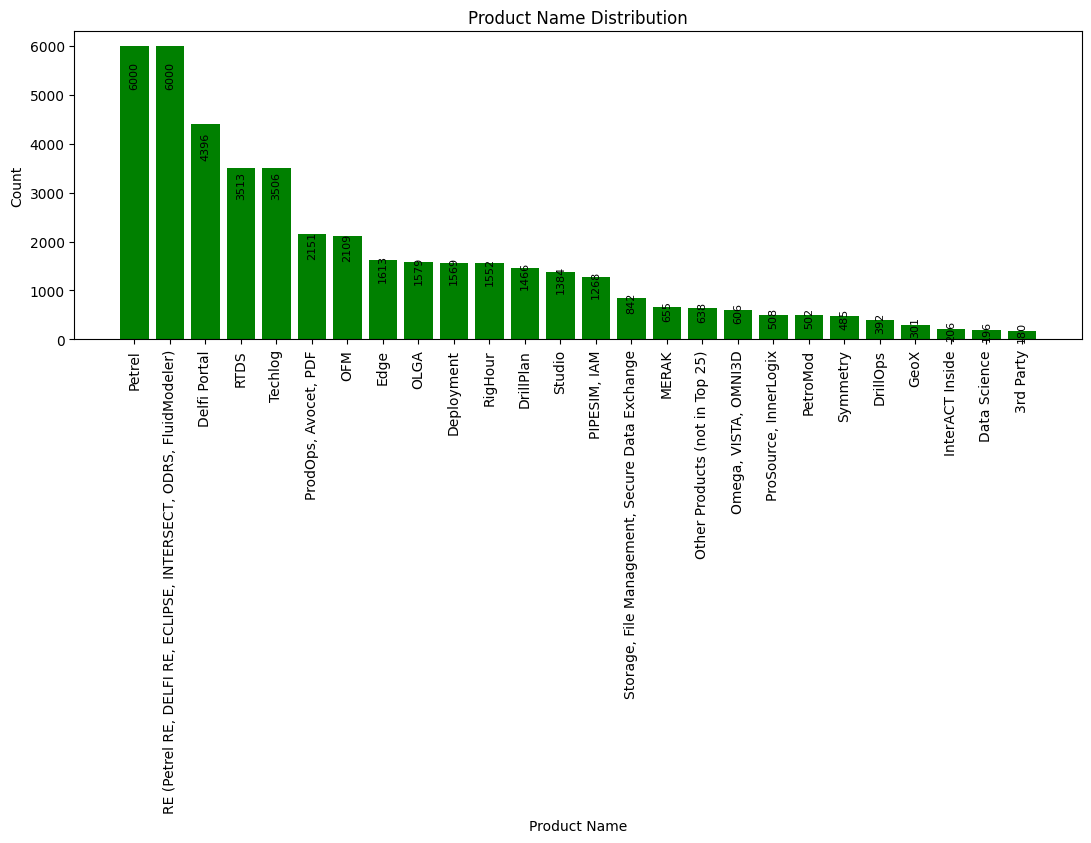

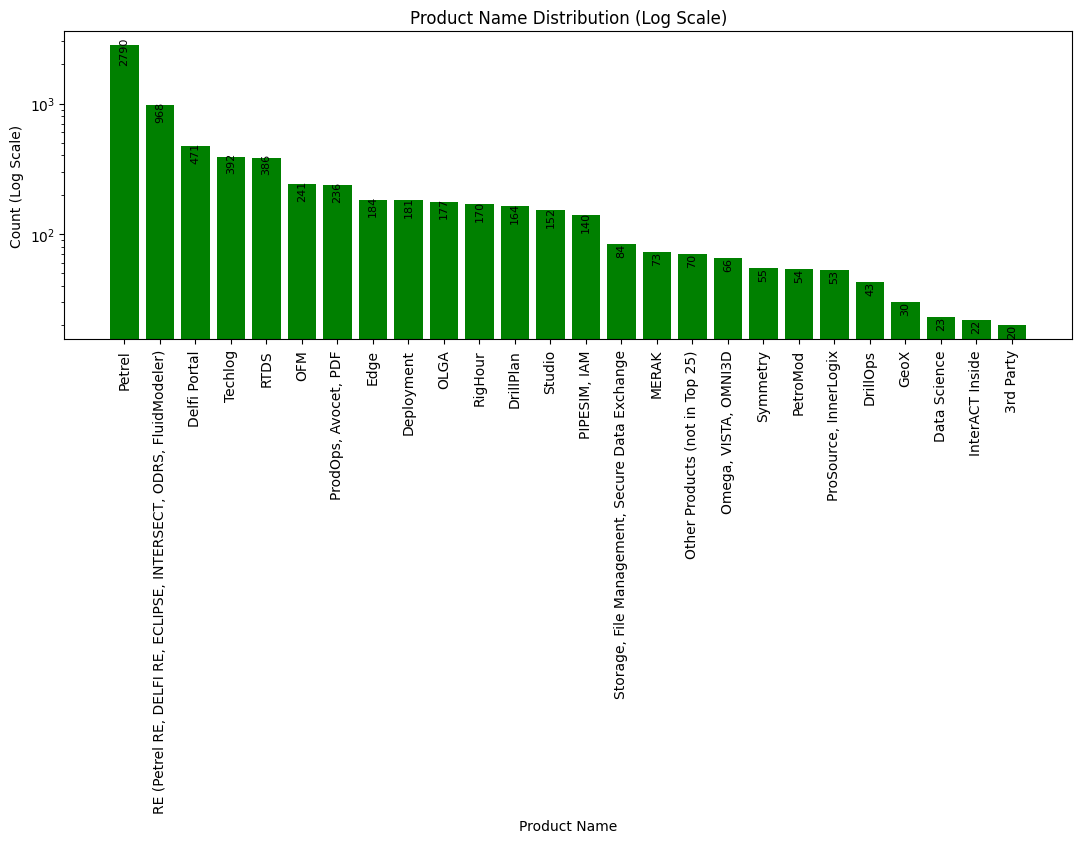

In [100]:
train_data = pipeline_data_prep_train.fit_transform(df_train)
test_data = pipeline_data_prep_test.fit_transform(df_test)
hist_by_labels(train_data, TARGET_COL, log=False, horizontal=True)
hist_by_labels(test_data, TARGET_COL, log=True, horizontal=True)

# Model Baseline - Cross Validation

In [8]:
# SciKit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Optuna
import optuna
import optuna.visualization as vis

# Others
import pickle

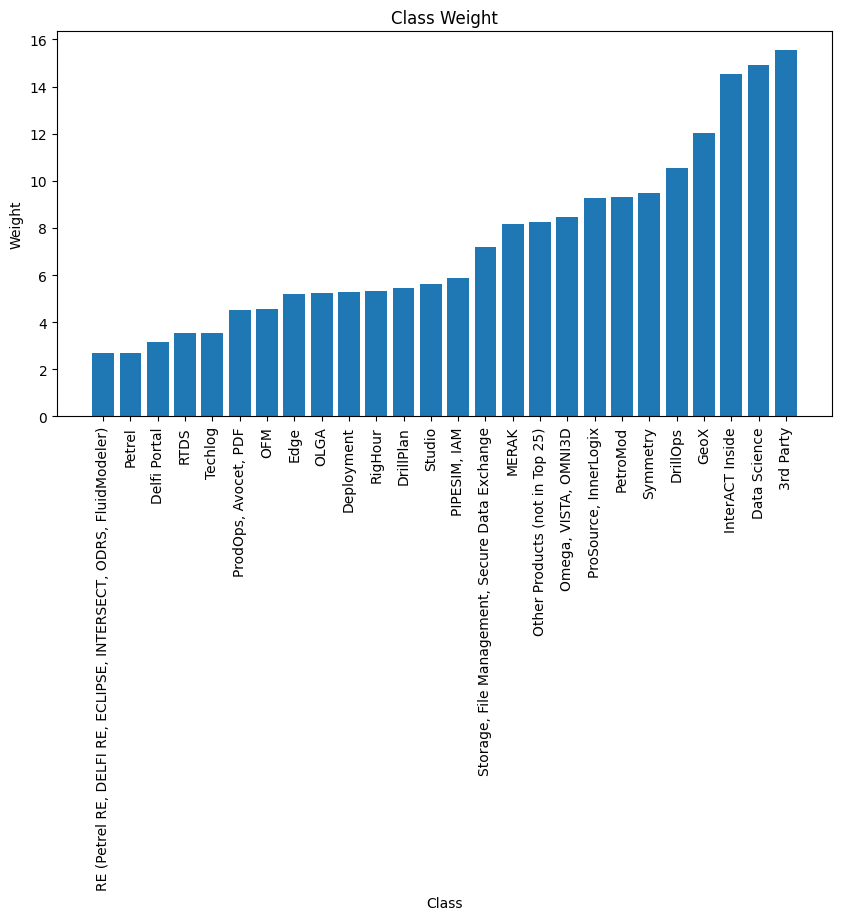

In [104]:
# create vectorizer for text
vectorizer_countvec = CountVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf = TfidfVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))

X = df_train[TEXT_COL]
vectorizer_countvec.fit(X)
vectorizer_tfidf.fit(X)

vectorizer = vectorizer_tfidf

X_train = train_data[TEXT_COL]
y_train = train_data[TARGET_COL]
X_train_encoded = vectorizer.transform(X_train)

X_test = test_data[TEXT_COL]
X_test_encoded = vectorizer.transform(X_test)
y_test = test_data[TARGET_COL]

# calculate the class weight of X_train
class_weight = dict()
for label in y_train.unique():
    class_weight[label] = len(y_train)/len(y_train[y_train==label])

# apply power to the class weight
class_weight = {k: np.power(v, CLASS_WEIGHT_POWER) for k, v in class_weight.items()}
class_weight_max = min(class_weight.values())*CLASS_WEIGHT_FACTOR
# apply sqrt() to the class weight

for label in class_weight.keys():
    if CLASS_WEIGHT_FACTOR >= 1:
        class_weight[label] = min(class_weight_max, class_weight[label])
plot_class_weights(class_weight)

In [105]:
# create a dictionary of models
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000, class_weight=class_weight ),
    'LogisticRegression': LogisticRegression(max_iter=5000, class_weight=class_weight),
    'SVC linear': SVC(kernel='linear', class_weight=class_weight),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(class_weight=class_weight)
    # 'SVC rbf': SVC(kernel='rbf'),
}

print(f'Configuration: Classify top \033[94m{TOP_N_PRODUCTS}\033[0m products; Text column: \033[94m{TEXT_COL}\033[0m, Title words length: (\033[94m{TITLE_WORDS_MIN}\033[0m, \033[94m{TITLE_WORDS_MAX}\033[0m);')
print(f'Records/product caped at \033[94m{PRODUCT_SIZE_MAX_TRAIN}\033[0m; Class weight factor: \033[94m{CLASS_WEIGHT_FACTOR}\033[0m; class weight power: \033[94m{CLASS_WEIGHT_POWER}\033[0m.')
print('Baseline Score(s) of each model are ....')

# Define the custom scoring function using f1_score
from sklearn.metrics import f1_score, make_scorer
scoring = make_scorer(f1_score, average='weighted')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded,
        y_train, #the target
        cv=5, 
        # scoring='accuracy', # lease revise to the appropriate score
        scoring=scoring,
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
Records/product caped at 6000; Class weight factor: -1; class weight power: 0.5.
Baseline Score(s) of each model are ....
Average score: 0.8253 by SGDClassifier.
Average score: 0.8206 by LogisticRegression.
Average score: 0.8074 by SVC linear.


In [42]:
# Best scores so far...##############################################
# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 6000; Class weight factor: -1; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8253 by SGDClassifier.
# Average score: 0.8206 by LogisticRegression.
# Average score: 0.8074 by SVC linear.
# Best scores so far...##############################################

# # Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 4000; Class weight factor: 5; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8275 by SGDClassifier.
# Average score: 0.8219 by LogisticRegression.
# Average score: 0.8070 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 4000; Class weight factor: 4; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8272 by SGDClassifier.
# Average score: 0.8220 by LogisticRegression.
# Average score: 0.8070 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 2000; Class weight factor: 4; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8239 by SGDClassifier.
# Average score: 0.8201 by LogisticRegression.
# Average score: 0.8039 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 4000; Class weight factor: 3; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8275 by SGDClassifier.
# Average score: 0.8217 by LogisticRegression.
# Average score: 0.8070 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 4000; Class weight factor: 2; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8271 by SGDClassifier.
# Average score: 0.8208 by LogisticRegression.
# Average score: 0.8071 by SVC linear.

# # Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15); 
# Records/product caped at 4000; class factor: 1; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8235 by SGDClassifier.
# Average score: 0.8146 by LogisticRegression.
# Average score: 0.8102 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 2000; Class weight factor: 1; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8234 by SGDClassifier.
# Average score: 0.8150 by LogisticRegression.
# Average score: 0.8046 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 4000; Class weight factor: -1; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8270 by SGDClassifier.
# Average score: 0.8219 by LogisticRegression.
# Average score: 0.8070 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 2000; Class weight factor: -1; class weight power: 0.5.
# Baseline Score(s) of each model are ....
# Average score: 0.8245 by SGDClassifier.
# Average score: 0.8201 by LogisticRegression.
# Average score: 0.8039 by SVC linear.

# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 2000; Class weight factor: -1; class weight power: 0.75.
# Baseline Score(s) of each model are ....
# Average score: 0.8171 by SGDClassifier.
# Average score: 0.8183 by LogisticRegression.
# Average score: 0.7997 by SVC linear.

# Hpyerparameter Tuning

## SGC Classifier (5min/100trials)

In [106]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [107]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-7, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']), #'hinge and square_hinge doesn't work with model.predict_proba() and is very slow
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=300, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

[I 2023-10-31 18:03:04,471] A new study created in RDB with name: sgd_classifier


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-10-31 18:03:10,036] Trial 8 finished with value: 0.8238302714716002 and parameters: {'alpha': 0.0003907134545245413, 'eta0': 0.0010417634141607558, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 8 with value: 0.8238302714716002.
[I 2023-10-31 18:03:12,624] Trial 0 finished with value: 0.7697230355876938 and parameters: {'alpha': 0.0008113232151791365, 'eta0': 0.022296819561786807, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 8 with value: 0.8238302714716002.
[I 2023-10-31 18:03:13,304] Trial 2 finished with value: 0.782837098485282 and parameters: {'alpha': 0.00026048832002750625, 'eta0': 0.07343416606439689, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 8 with value: 0.8238302714716002.
[I 2023-10-31 18:03:13,362] Trial 7 finished with value: 0.8033795381338621 and parameters: {'alpha': 1.567101615864848e-06, 'eta0': 0.03353425025624157, 'loss': 'log_loss', 'pena

In [108]:
vis.plot_optimization_history(study)

In [109]:
vis.plot_slice(study)

Accuracy: 0.827467 on test data size 7245
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.250     0.200     0.222        20
                                                    Data Science      0.519     0.609     0.560        23
                                                    Delfi Portal      0.598     0.737     0.660       471
                                                      Deployment      0.713     0.619     0.663       181
                                                        DrillOps      0.833     0.698     0.759        43
                                                       DrillPlan      0.727     0.829     0.775       164
                                                            Edge      0.984     0.989     0.986       184
                                                            GeoX      0.862     0.833     0.847        30
   

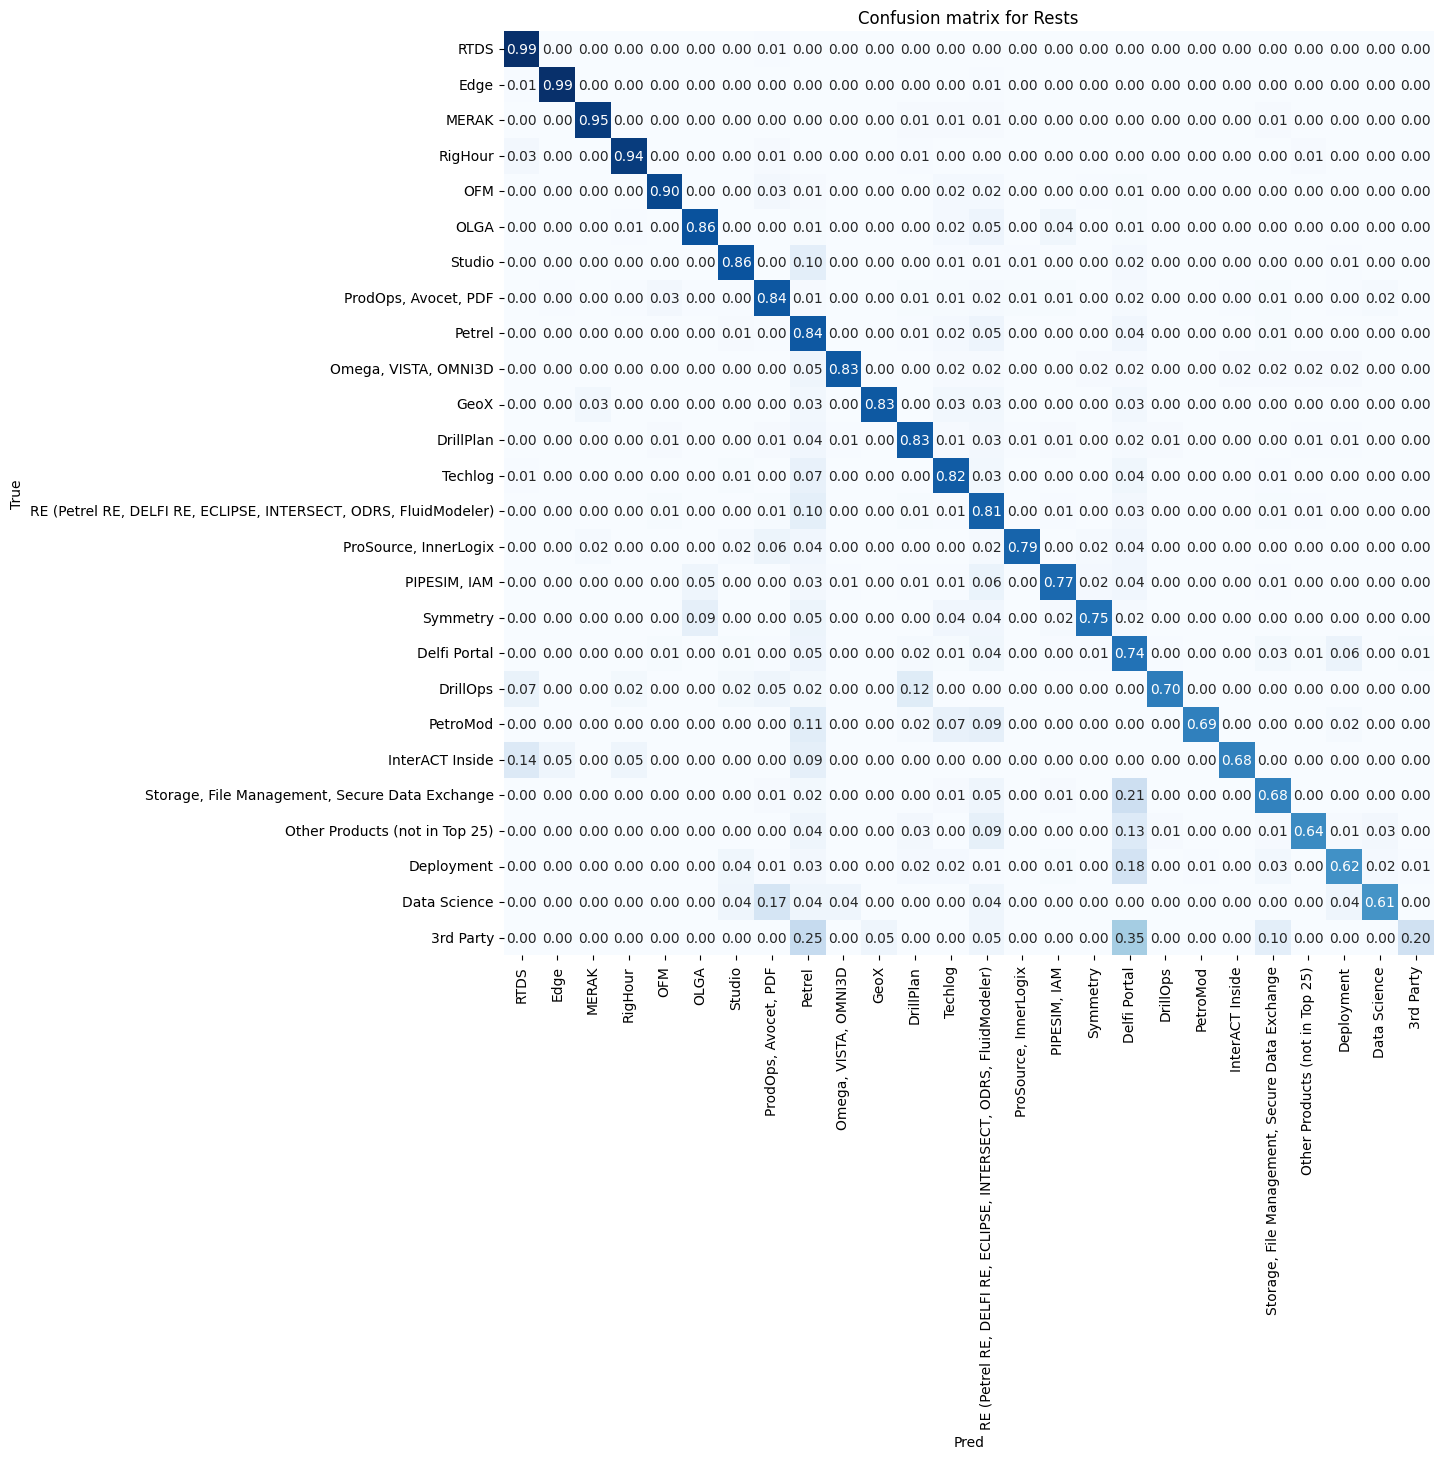

Accuracy of top 1 prediction is 0.828.
Accuracy of top 3 prediction is 0.947.
Accuracy of top 5 prediction is 0.972.


In [110]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(class_weight=class_weight, **best_params)
best_model_sgc.fit(X_train_encoded, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m on test data size \033[94m{len(y_test)}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [111]:
# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 6000; Class weight factor: -1; class weight power: 0.5.
# Accuracy of top 1 prediction is 0.828.
# Accuracy of top 3 prediction is 0.947.
# Accuracy of top 5 prediction is 0.972.
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification (10min/10trials)

In [112]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [117]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']), #sag and 'saga' are is slow to converge
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 50000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-31 18:23:26,046] Using an existing study with name 'logReg' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-10-31 18:26:43,461] Trial 17 finished with value: 0.8212624973961704 and parameters: {'solver': 'liblinear', 'C': 1.5370901446745615}. Best is trial 6 with value: 0.823027847822084.
[I 2023-10-31 18:26:44,125] Trial 19 finished with value: 0.8218814952833038 and parameters: {'solver': 'liblinear', 'C': 2.11353300959304}. Best is trial 6 with value: 0.823027847822084.
[I 2023-10-31 18:26:49,103] Trial 11 finished with value: 0.8217209974127014 and parameters: {'solver': 'liblinear', 'C': 1.9263980252293034}. Best is trial 6 with value: 0.823027847822084.
[I 2023-10-31 18:26:51,711] Trial 18 finished with value: 0.8216063894914776 and parameters: {'solver': 'liblinear', 'C': 2.420880544064569}. Best is trial 6 with value: 0.823027847822084.
[I 2023-10-31 18:26:55,021] Trial 16 finished with value: 0.8216293173832578 and parameters: {'solver': 'liblinear', 'C': 2.4164069139170916}. Best is trial 6 with value: 0.823027847822084.
[I 2023-10-31 18:26:55,460] Trial 14 finished with va

In [118]:
vis.plot_optimization_history(study)

In [119]:
vis.plot_slice(study)

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.8195
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.267     0.200     0.229        20
                                                    Data Science      0.583     0.609     0.596        23
                                                    Delfi Portal      0.609     0.735     0.666       471
                                                      Deployment      0.672     0.680     0.676       181
                                                        DrillOps      0.861     0.721     0.785        43
                                                       DrillPlan      0.725     0.835     0.776       164
                                                            Edge      0.978     0.989     0.984       184
                                                            GeoX      0.839     0.867     0.852        30
                            

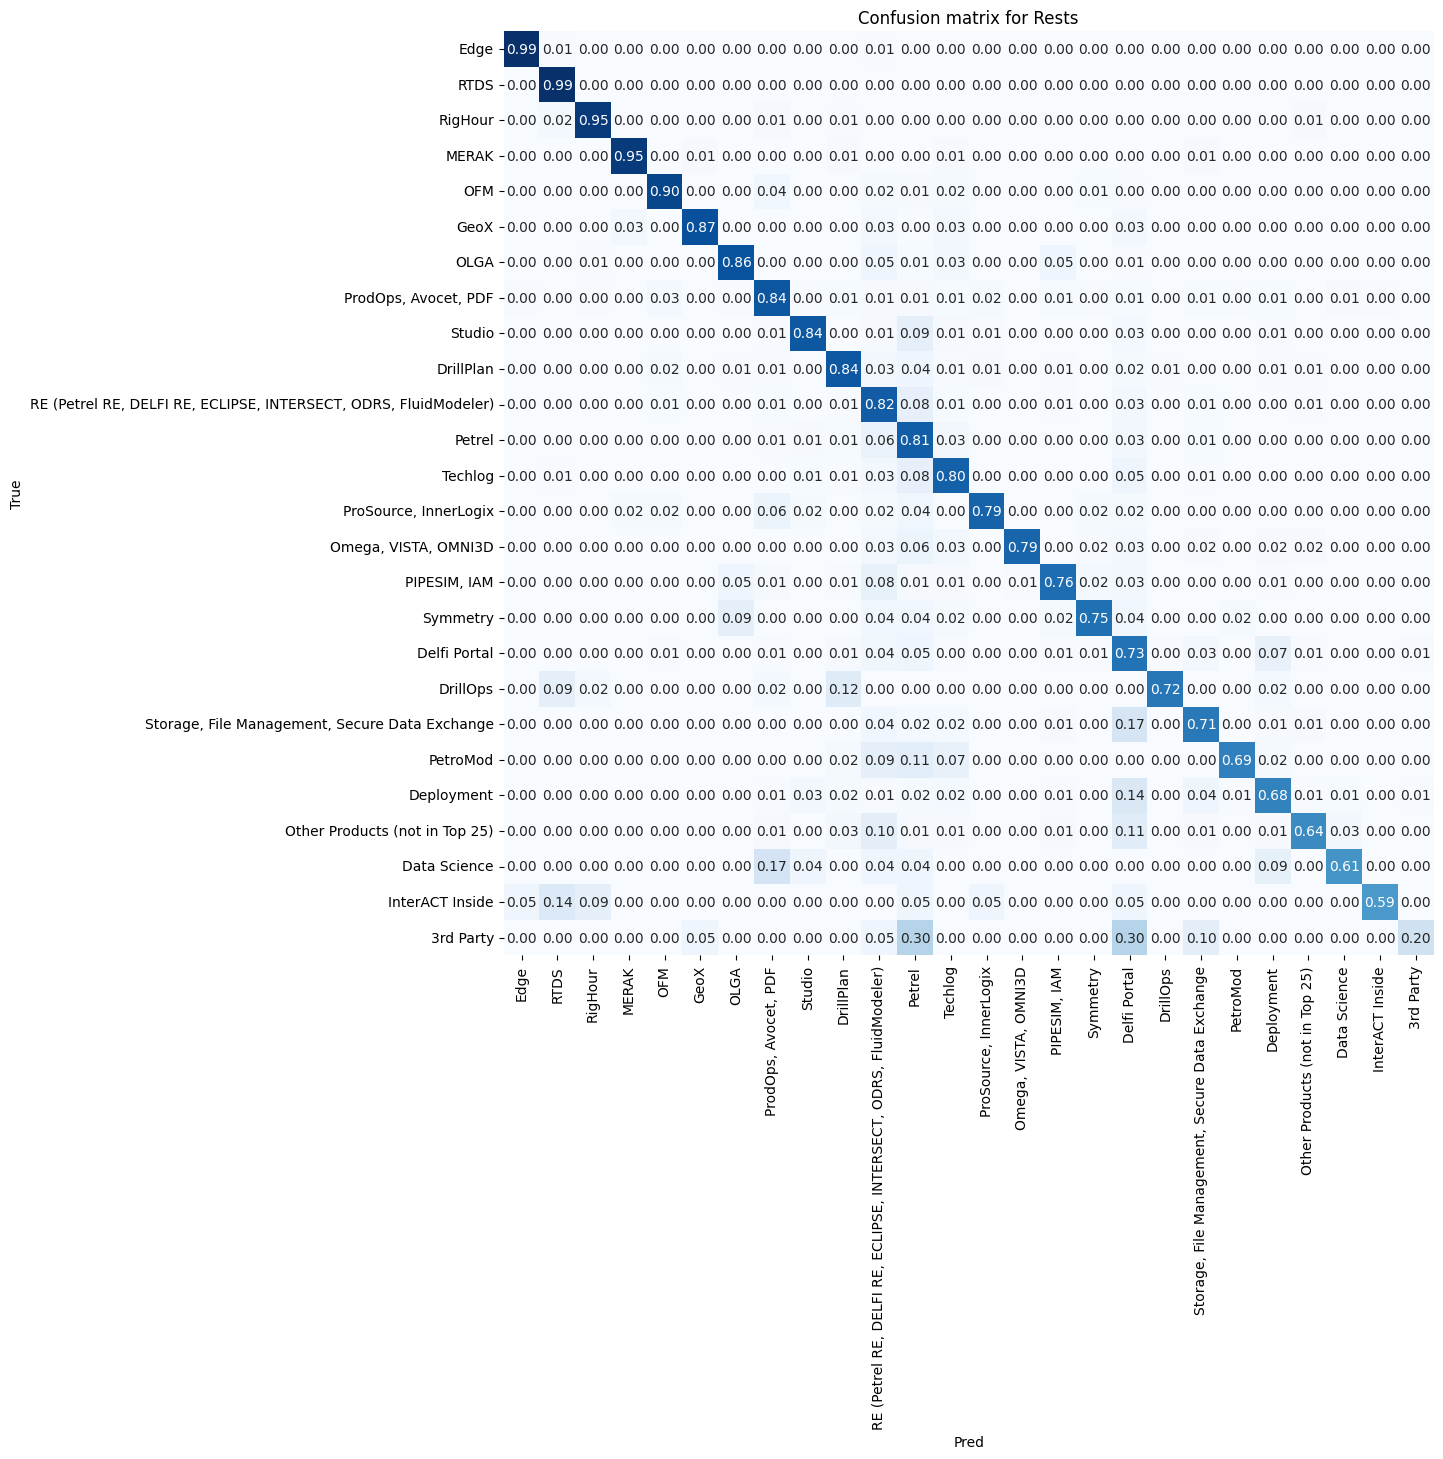

Accuracy of top 1 prediction is 0.819.
Accuracy of top 3 prediction is 0.951.
Accuracy of top 5 prediction is 0.974.


In [120]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(class_weight=class_weight, **best_params)
best_model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [121]:
# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 6000; Class weight factor: -1; class weight power: 0.5.
# Accuracy of top 1 prediction is 0.819.
# Accuracy of top 3 prediction is 0.951.
# Accuracy of top 5 prediction is 0.974.
# export the model
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB (2min)

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.789.
# Accuracy of top 3 prediction is 0.927.
# Accuracy of top 5 prediction is 0.956.
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear (100min/20trials)

In [122]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Clean up the study if it exists
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [123]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=20, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

[I 2023-10-31 18:28:35,209] A new study created in RDB with name: SVC_linear


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-31 19:05:14,150] Trial 9 finished with value: 0.7890960712831414 and parameters: {'C': 35.00600667313255}. Best is trial 9 with value: 0.7890960712831414.
[I 2023-10-31 19:06:05,392] Trial 3 finished with value: 0.8125044737510068 and parameters: {'C': 0.5759992810548568}. Best is trial 3 with value: 0.8125044737510068.
[I 2023-10-31 19:06:20,110] Trial 7 finished with value: 0.7929936814788101 and parameters: {'C': 5.8520384017101135}. Best is trial 3 with value: 0.8125044737510068.
[I 2023-10-31 19:08:26,394] Trial 0 finished with value: 0.8095469885906669 and parameters: {'C': 0.12189898911143508}. Best is trial 3 with value: 0.8125044737510068.
[I 2023-10-31 19:08:57,266] Trial 8 finished with value: 0.7888438749861169 and parameters: {'C': 37.375331416102476}. Best is trial 3 with value: 0.8125044737510068.
[I 2023-10-31 19:09:12,305] Trial 2 finished with value: 0.7960658350075899 and parameters: {'C': 2.948789318865314}. Best is trial 3 with value: 0.8125044737510068.

In [124]:
vis.plot_optimization_history(study)

In [125]:
vis.plot_slice(study)

Accuracy: 0.819048
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.292     0.350     0.318        20
                                                    Data Science      0.500     0.652     0.566        23
                                                    Delfi Portal      0.581     0.724     0.645       471
                                                      Deployment      0.731     0.630     0.677       181
                                                        DrillOps      0.786     0.767     0.776        43
                                                       DrillPlan      0.730     0.823     0.774       164
                                                            Edge      0.984     0.989     0.986       184
                                                            GeoX      0.788     0.867     0.825        30
                          

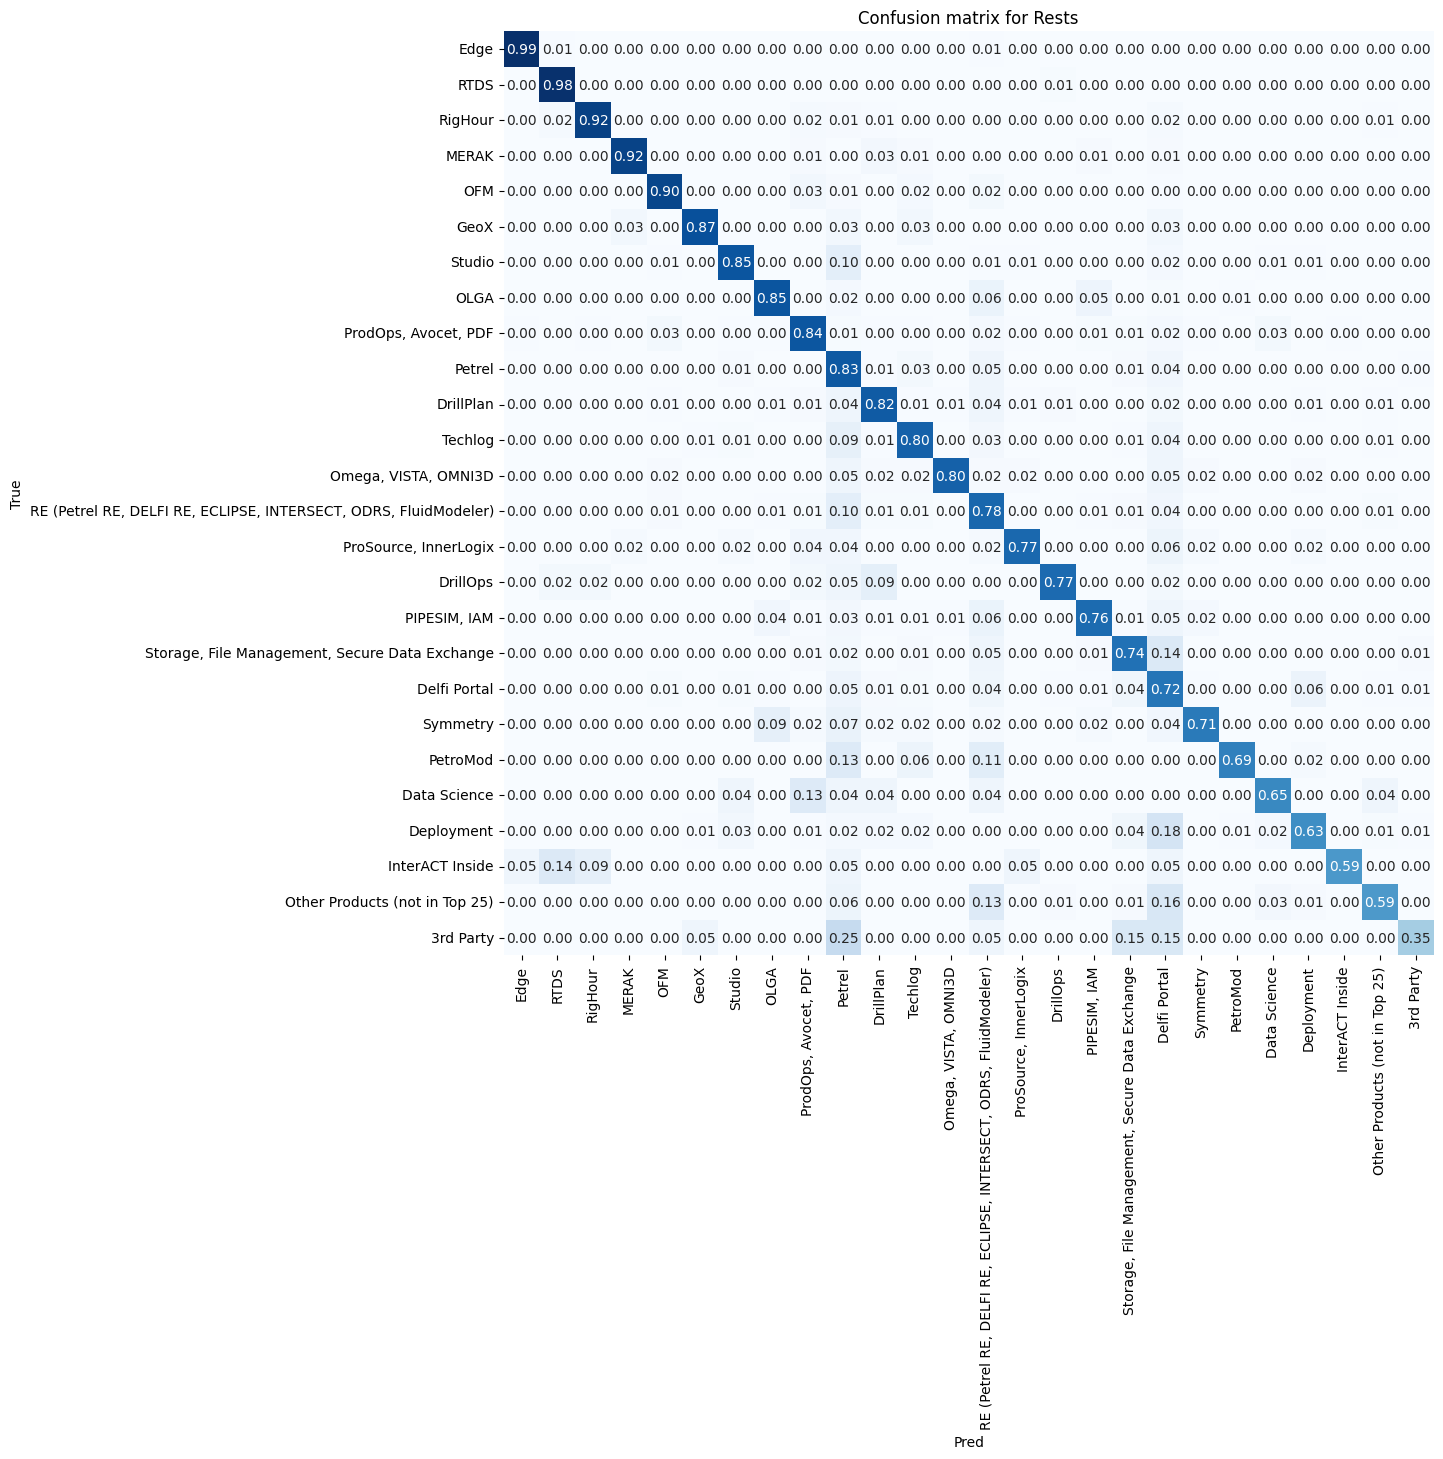

Accuracy of top 1 prediction is 0.819.
Accuracy of top 3 prediction is 0.952.
Accuracy of top 5 prediction is 0.978.


In [126]:
# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', probability=True, class_weight=class_weight, **best_params)
best_model_svc_linear.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [127]:
# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15);
# Records/product caped at 6000; Class weight factor: -1; class weight power: 0.5.
# Accuracy of top 1 prediction is 0.819.
# Accuracy of top 3 prediction is 0.952.
# Accuracy of top 5 prediction is 0.978.
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

In [194]:
from sklearn.ensemble import VotingClassifier

# load the models
model_logistic_regression = pickle.load(open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'rb'))
model_svc_linear = pickle.load(open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'rb'))
model_sgc_classifier = pickle.load(open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'rb'))

# Create a dictionary of the models
estimators = [
    ('logReg', model_logistic_regression),
    ('svc_linear', model_svc_linear),
    ('sgc_classifier', model_sgc_classifier),
]

# Create a voting classifier with soft voting and best_model_logReg.classes_,
voting = VotingClassifier(
    estimators, 
    voting='soft', 
    n_jobs=-1
    )

# Fit the voting classifier to the training data
voting.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer, X_test, y_test, pre_processed=True)

ValueError: The classes, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], are not in class_weight

In [169]:
voting.classes_= best_model_logReg.classes_
voting.classes_

array(['3rd Party', 'Data Science', 'Delfi Portal', 'Deployment',
       'DrillOps', 'DrillPlan', 'Edge', 'GeoX', 'InterACT Inside',
       'MERAK', 'OFM', 'OLGA', 'Omega, VISTA, OMNI3D',
       'Other Products (not in Top 25)', 'PIPESIM, IAM', 'Petrel',
       'PetroMod', 'ProSource, InnerLogix', 'ProdOps, Avocet, PDF',
       'RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, ODRS, FluidModeler)',
       'RTDS', 'RigHour',
       'Storage, File Management, Secure Data Exchange', 'Studio',
       'Symmetry', 'Techlog'], dtype=object)

In [174]:
class_weight

{'MERAK': 8.160321053405712,
 'RigHour': 5.30129579569015,
 'ProdOps, Avocet, PDF': 4.503059551877427,
 'OFM': 4.547676942803042,
 'Studio': 5.6138376722527905,
 'PIPESIM, IAM': 5.865003408714025,
 'Delfi Portal': 3.1499165897358288,
 'DrillPlan': 5.454574910003563,
 'Techlog': 3.5271338409215636,
 'ProSource, InnerLogix': 9.26607987341316,
 'RTDS': 3.5236180070984937,
 'PetroMod': 9.321290371148564,
 'RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, ODRS, FluidModeler)': 2.6962010310805833,
 'Storage, File Management, Secure Data Exchange': 7.197337195646629,
 'OLGA': 5.25577579690754,
 'Deployment': 5.272498002052192,
 'Data Science': 14.917630987717663,
 'Petrel': 2.6962010310805833,
 'Edge': 5.200088224727279,
 'Omega, VISTA, OMNI3D': 8.483822695268476,
 'GeoX': 12.037731378635513,
 'DrillOps': 10.548358030653734,
 'Other Products (not in Top 25)': 8.268325329941698,
 'Symmetry': 9.48324621439761,
 'InterACT Inside': 14.551048405827597,
 '3rd Party': 15.566523910837212}

ValueError: The classes, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], are not in class_weight

In [ ]:
# Accuracy of top 1 prediction is 0.824.
# Accuracy of top 3 prediction is 0.936.
# Accuracy of top 5 prediction is 0.963.
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))